In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns

## Happiness and Marriage

The function to simulate data is a modified version of the function in: https://github.com/pymc-devs/resources/blob/master/Rethinking_2/Chp_06.ipynb

In [2]:
def sigmoid(x):
    return np.exp(x) / (1 + np.exp(x))


def sim_happiness(N_years=1000, seed=1234):
    np.random.seed(seed)

    population = pd.DataFrame(np.zeros((20 * 65, 3)), columns=["age", "happiness", "married"])
    population.loc[:, "age"] = np.repeat(np.arange(1, 66), 20)
    population.loc[:, "happiness"] = np.tile(np.linspace(-2, 2, 20), 65)

    for i in range(N_years):
        # age population
        population.loc[:, "age"] += 1
        
        # replace old folk with new folk
        idx = population.age > 65
        population.loc[idx, "age"] = 1
        population.loc[idx, "married"] = 0
        population.loc[idx, "happiness"] = np.linspace(-2, 2, 20)

        # do the work
        eligible = (population.married == 0) & (population.age >= 18)
        marriage_prob = sigmoid(population.loc[eligible, "happiness"] - 4.0)
        will_marry = np.random.binomial(n=1, p=marriage_prob)
        population.loc[eligible, "married"] = will_marry

    population.sort_values("age", inplace=True, ignore_index=True)

    return population


### Code 6.21

In [3]:
df = sim_happiness(N_years=1000)
df.describe([0.055, 0.945])

,age,happiness,married
count,1300.000000,1.300000e+03,1300.000000
mean,33.000000,-1.004325e-16,0.286923
std,18.768883,1.214421e+00,0.452499
min,1.000000,-2.000000e+00,0.000000
5.5%,4.000000,-1.789474e+00,0.000000
50%,33.000000,-1.110223e-16,0.000000
94.5%,62.000000,1.789474e+00,1.000000
max,65.000000,2.000000e+00,1.000000


### Figure 6.4

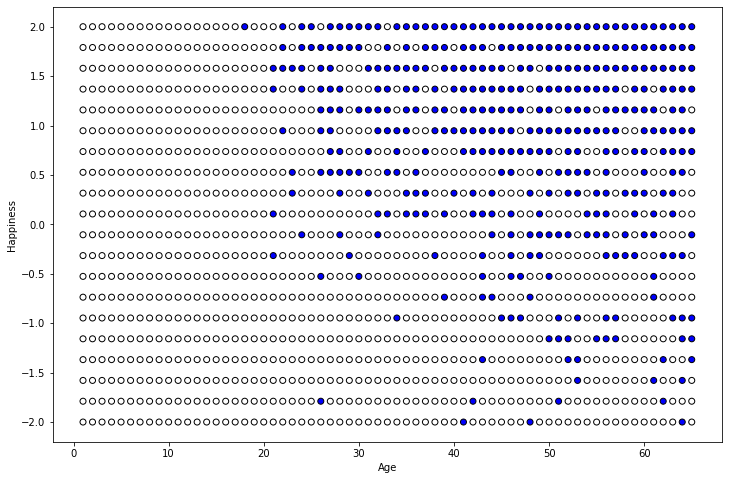

In [4]:
fig, ax = plt.subplots(figsize=[12, 8])
colors = np.where(df['married'] == 1, 'b', 'w')
ax.scatter(df['age'], df['happiness'], edgecolor='k', color=colors)

ax.set_xlabel('Age')
ax.set_ylabel('Happiness')

plt.show()

In [5]:
df['not_married'] = np.where(df['married'] == 1, 0, 1)

df_2 = df[df['age'] >= 18].copy()
# A == 0 => age 18 and A == 1 => age 65
df_2['A'] = (df_2['age'] - 18) / (65 - 18)

## The Model

$$
\begin{array}
    \text{happiness}            & \sim N(\mu, \sigma) \\
    \mu                         & \sim \alpha_{\text{married}} + \alpha_{\text{not married}} + \beta_{A} \cdot A \\
    \sigma                      & \sim \text{Exponential}(1) \\                                                     
    \alpha_{\text{married}}     & \sim N(0, 1) \\
    \alpha_{\text{not married}} & \sim N(0, 1) \\
    \beta_{A}                   & \sim N(0, 2) \\
\end{array}
$$

### Code 6.23

In [6]:
with pm.Model() as m_6_9:
    a_m = pm.Normal('a_m', mu=0, sigma=1)
    a_n = pm.Normal('a_n', mu=0, sigma=1)
    b_A = pm.Normal('b_A', mu=0, sigma=2)
    sigma = pm.Exponential('sigma', lam=1)
    
    mu = pm.Deterministic('mu', a_m * df_2['married'] + a_n * df_2['not_married'] + b_A * df_2['A'])
    happiness = pm.Normal('happiness', mu=mu, sigma=sigma, observed=df_2['happiness'])
    
    trace_6_9 = pm.sample(2000, init='advi', tune=2000)

az.summary(trace_6_9, var_names=['a_m', 'a_n', 'b_A', 'sigma'], hdi_prob=0.89)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Convergence achieved at 18800
Interrupted at 18,799 [9%]: Average Loss = 1,729.1
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b_A, a_n, a_m]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 14 seconds.
/home/somnath/install/anaconda3/envs/stat-rethink-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a_m,1.192,0.087,1.053,1.327,0.002,0.001,2491.0,2486.0,2492.0,3491.0,1.0
a_n,-0.232,0.066,-0.339,-0.128,0.001,0.001,2535.0,2535.0,2536.0,3773.0,1.0
b_A,-0.645,0.115,-0.822,-0.454,0.003,0.002,2093.0,2093.0,2093.0,2962.0,1.0
sigma,1.015,0.023,0.975,1.049,0.000,0.000,12188.0,12121.0,12270.0,6308.0,1.0


### Code 6.24

In [7]:
with pm.Model() as m_6_10:
    a = pm.Normal('a', mu=0, sigma=1)
    b_A = pm.Normal('b_A', mu=0, sigma=2)
    sigma = pm.Exponential('sigma', lam=1)
    
    mu = pm.Deterministic('mu', a + b_A * df_2['A'])
    happiness = pm.Normal('happiness', mu=mu, sigma=sigma, observed=df_2['happiness'])
    
    trace_6_10 = pm.sample(2000, init='advi', tune=2000)

az.summary(trace_6_10, var_names=['a', 'b_A', 'sigma'], hdi_prob=0.89)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Convergence achieved at 18500
Interrupted at 18,499 [9%]: Average Loss = 1,885
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b_A, a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 12 seconds.
The number of effective samples is smaller than 25% for some parameters.
/home/somnath/install/anaconda3/envs/stat-rethink-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-0.002,0.077,-0.126,0.118,0.002,0.001,1680.0,1680.0,1680.0,2561.0,1.0
b_A,0.002,0.132,-0.208,0.210,0.003,0.002,1698.0,1698.0,1698.0,2909.0,1.0
sigma,1.216,0.028,1.174,1.264,0.000,0.000,11368.0,11368.0,11346.0,6225.0,1.0


## The Influence of Grandparents and Parents on Children

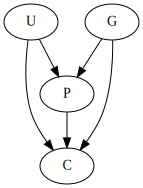

In [8]:
from causalgraphicalmodels import CausalGraphicalModel


grandparents = CausalGraphicalModel(
    nodes=["G", "P", "C", "U"],
    edges=[
        ("G", "P"), 
        ("P", "C"), 
        ("G", "C"),
        ("U", "P"), 
        ("U", "C")
    ]
)

# draw return a graphviz `dot` object, which jupyter can render
grandparents.draw()

## Simulation

### Code 6.25

In [9]:
N = 2000
b_GP = 1
b_GC = 0
b_PC = 1
b_U = 2 

### Code 6.26

In [10]:
from scipy.stats import norm, bernoulli


U = 2 * bernoulli.rvs(p=0.5, size=N) - 1
G = norm.rvs(loc=0, scale=1, size=N)
P = norm.rvs(loc=b_GP * G + b_U * U, scale=1, size=N)
C = norm.rvs(loc=b_GC * G + b_PC * P + b_U * U, scale=1, size=N)

df_gp = pd.DataFrame({'C': C, 'G': G, 'P': P, 'U': U})

df_gp.head()

,C,G,P,U
0,-2.969173,0.394473,-2.615048,-1
1,3.197398,0.570252,2.107089,1
2,2.227170,-0.440848,0.585755,1
3,-3.133699,0.682509,-0.469667,-1
4,3.739784,0.409995,2.439433,1


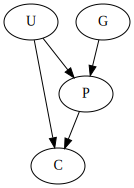

In [11]:
gp_sim = CausalGraphicalModel(
    nodes=["G", "P", "C", "U"],
    edges=[
        ("G", "P"), 
        ("P", "C"), 
        ("U", "P"), 
        ("U", "C")
    ]
)

# draw return a graphviz `dot` object, which jupyter can render
gp_sim.draw()

### Code 6.27

In [12]:
with pm.Model() as m_6_11:
    a = pm.Normal('a', mu=0, sigma=1)
    b_GC = pm.Normal('b_GC', mu=0, sigma=1)
    b_PC = pm.Normal('b_PC', mu=0, sigma=1)
    sigma = pm.Exponential('sigma', lam=1)
    
    mu = pm.Deterministic('mu', a + b_GC * df_gp['G'] + b_PC * df_gp['P'])
    C = pm.Normal('C', mu=mu, sigma=sigma, observed=df_gp['C'])
    
    trace_6_11 = pm.sample(2000, init='advi', tune=2000)

az.summary(trace_6_11, var_names=['a', 'b_GC', 'b_PC', 'sigma'], hdi_prob=0.89)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Convergence achieved at 15600
Interrupted at 15,599 [7%]: Average Loss = 12,491
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b_PC, b_GC, a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 16 seconds.
/home/somnath/install/anaconda3/envs/stat-rethink-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-0.005,0.031,-0.055,0.045,0.001,0.0,3305.0,2944.0,3309.0,3451.0,1.0
b_GC,-0.846,0.033,-0.897,-0.792,0.000,0.0,5239.0,5237.0,5242.0,5318.0,1.0
b_PC,1.809,0.014,1.788,1.831,0.000,0.0,7477.0,7477.0,7496.0,6784.0,1.0
sigma,1.345,0.021,1.313,1.379,0.000,0.0,9000.0,8918.0,8986.0,5713.0,1.0


In [13]:
summary_6_11 = az.summary(trace_6_11, var_names=['a', 'b_GC', 'b_PC', 'sigma'], hdi_prob=0.89)

a = summary_6_11.loc['a', 'mean']
b_GC = summary_6_11.loc['b_GC', 'mean']
b_PC = summary_6_11.loc['b_PC', 'mean']

quant = df_gp['P'].quantile([0.45, 0.60])

/home/somnath/install/anaconda3/envs/stat-rethink-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


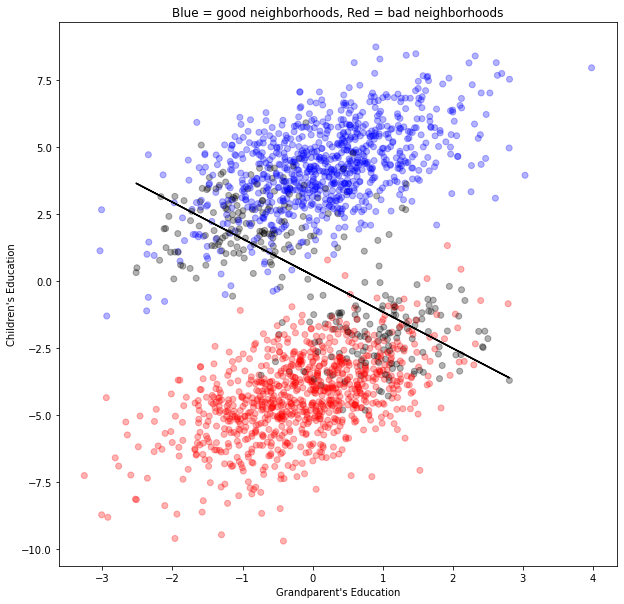

In [14]:
lower = quant.loc[0.45, ]
upper = quant.loc[0.60, ]

df_gp_prime = df_gp[(df_gp['P'] >= lower) & (df_gp['P'] <= upper)]

m, c = np.polyfit(df_gp_prime['G'].values, df_gp_prime['C'].values, deg=1)

fig, ax = plt.subplots(figsize=(10, 10))

# Blue = good neighborhoods, Red = Bad neighborhoods 
colors = np.where(df_gp['U'] == 1, 'b', 'r')

# Get the index where parents have an education between the 45th and 60th percentiles 
c_idx = df_gp[(df_gp['P'] >= lower) & (df_gp['P'] <= upper)].index

# Mark them black
colors[c_idx] = 'k'

ax.scatter(df_gp['G'], df_gp['C'], color=colors, alpha=0.3)

ax.set_xlabel("Grandparent's Education")
ax.set_ylabel("Children's Education")
ax.set_title('Blue = good neighborhoods, Red = bad neighborhoods')

ax.plot(df_gp_prime['G'], c + m * df_gp_prime['G'], 'k')

## Discussion

In the above regression, we ignored the variable $U$ and included $P$ and $G$. Conditioning on $P$ resulted in  a negative association between $G$ and $C$. To see this, consider two parents $P_1$ and $P_2$ with the same education. Since the variables actually represent the education levels here, this means that $P_1 = P_2$. Let $G_1$ and $G_2$, the parents of $P_1$ and $P_2$, respectively, be such that $G_1 < G_2$. Then for both $P_1$ and $P_2$ to have the same education, it must be that $P_1$ lives in a good neighborhood and $P_2$ lives in a bad neigborhood. That is, if we condition on $P$, then the knowledge of $G$ tells us the neighborhood type where $P$ lives in. Since neighborhood type influences the education of children too, we have $C_1 > C_2$. Thus, $G$ is negatively associated with $C$.

## Conditioning on $U$ too

### Code 6.28

In [15]:
with pm.Model() as m_6_12:
    a = pm.Normal('a', mu=0, sigma=1)
    b_GC = pm.Normal('b_GC', mu=0, sigma=1)
    b_PC = pm.Normal('b_PC', mu=0, sigma=1)
    b_U = pm.Normal('b_U', mu=0, sigma=1)
    sigma = pm.Exponential('sigma', lam=1)
    
    mu = pm.Deterministic('mu', a + b_GC * df_gp['G'] + b_PC * df_gp['P'] + b_U * df_gp['U'])
    C = pm.Normal('C', mu=mu, sigma=sigma, observed=df_gp['C'])
    
    trace_6_12 = pm.sample(2000, init='advi', tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Convergence achieved at 25500
Interrupted at 25,499 [12%]: Average Loss = 8,510.9
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b_U, b_PC, b_GC, a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 20 seconds.


In [16]:
az.summary(trace_6_12, var_names=['a', 'b_GC', 'b_PC', 'b_U', 'sigma'], hdi_prob=0.89)

/home/somnath/install/anaconda3/envs/stat-rethink-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-0.011,0.022,-0.046,0.025,0.000,0.000,6664.0,5297.0,6640.0,5716.0,1.0
b_GC,-0.016,0.032,-0.069,0.032,0.001,0.000,3236.0,3236.0,3235.0,4445.0,1.0
b_PC,0.980,0.023,0.944,1.016,0.000,0.000,2624.0,2624.0,2627.0,3516.0,1.0
b_U,2.042,0.049,1.960,2.117,0.001,0.001,2735.0,2733.0,2734.0,3429.0,1.0
sigma,0.982,0.016,0.958,1.008,0.000,0.000,8600.0,8600.0,8597.0,5515.0,1.0


## Regressing $C$ on $G$

In [17]:
with pm.Model() as m_6_13:
    a = pm.Normal('a', mu=0, sigma=1)
    b_GC = pm.Normal('b_GC', mu=0, sigma=1)
    sigma = pm.Exponential('sigma', lam=1)
    
    mu = pm.Deterministic('mu', a + b_GC * df_gp['G'])
    C = pm.Normal('C', mu=mu, sigma=sigma, observed=df_gp['C'])
    
    trace_6_13 = pm.sample(2000, init='advi', tune=2000)
    
az.summary(trace_6_13, var_names=['a', 'b_GC', 'sigma'], hdi_prob=0.89)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Convergence achieved at 12400
Interrupted at 12,399 [6%]: Average Loss = 17,679
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b_GC, a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 11 seconds.
/home/somnath/install/anaconda3/envs/stat-rethink-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-0.112,0.091,-0.258,0.033,0.001,0.001,4302.0,3575.0,4322.0,3710.0,1.0
b_GC,0.998,0.093,0.857,1.158,0.001,0.001,3926.0,3926.0,3931.0,3685.0,1.0
sigma,4.200,0.066,4.087,4.298,0.001,0.001,7407.0,7401.0,7412.0,6190.0,1.0


## Discussion

If we regress $C$ on $G$ ignoring everything else, then we end up capturing the influence that parents have on their children. 

## Another Experiment

In [18]:
N_SAMPLES = 2000

c_GP = 2
c_PC = 1

Gr = norm.rvs(loc=0, scale=1, size=N_SAMPLES)
Pa = norm.rvs(loc=c_GP * Gr, scale=1, size=N_SAMPLES)
Ch = norm.rvs(loc=c_PC * Pa, scale=1, size=N_SAMPLES)

df_sim = pd.DataFrame({'C': Ch, 'G': Gr, 'P': Pa})

df_sim.head()

,C,G,P
0,-1.130731,-0.610303,-0.010609
1,0.956639,0.594711,2.924817
2,-0.324847,-1.283012,-1.017394
3,0.628781,-0.027782,0.524028
4,1.089454,-0.824542,0.175829


In [19]:
with pm.Model() as m_6_14:
    a = pm.Normal('a', mu=0, sigma=1)
    c_GC = pm.Normal('c_GC', mu=0, sigma=1)
    c_PC = pm.Normal('c_PC', mu=0, sigma=1)
    sigma = pm.Exponential('sigma', lam=1)
    
    mu = pm.Deterministic('mu', a + c_GC * df_sim['G'] + c_PC * df_sim['P'])
    C = pm.Normal('C', mu=mu, sigma=sigma, observed=df_sim['C'])
    
    trace_6_14 = pm.sample(2000, init='advi', tune=2000)

az.summary(trace_6_14, var_names=['a', 'c_GC', 'c_PC', 'sigma'], hdi_prob=0.89)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Convergence achieved at 24700
Interrupted at 24,699 [12%]: Average Loss = 5,024.3
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c_PC, c_GC, a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 10 seconds.
/home/somnath/install/anaconda3/envs/stat-rethink-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.010,0.022,-0.025,0.046,0.000,0.000,7088.0,4696.0,7106.0,5439.0,1.0
c_GC,0.105,0.050,0.025,0.184,0.001,0.001,2794.0,2767.0,2794.0,3402.0,1.0
c_PC,0.951,0.023,0.917,0.990,0.000,0.000,2713.0,2713.0,2715.0,3592.0,1.0
sigma,0.989,0.016,0.963,1.013,0.000,0.000,8093.0,8089.0,8101.0,5460.0,1.0


In [20]:
with pm.Model() as m_6_15:
    a = pm.Normal('a', mu=0, sigma=1)
    c_GC = pm.Normal('c_GC', mu=0, sigma=1)
    sigma = pm.Exponential('sigma', lam=1)
    
    mu = pm.Deterministic('mu', a + c_GC * df_sim['G'])
    C = pm.Normal('C', mu=mu, sigma=sigma, observed=df_sim['C'])
    
    trace_6_15 = pm.sample(2000, init='advi', tune=2000)

az.summary(trace_6_15, var_names=['a', 'c_GC', 'sigma'], hdi_prob=0.89)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Convergence achieved at 20200
Interrupted at 20,199 [10%]: Average Loss = 5,663.2
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c_GC, a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 12 seconds.
/home/somnath/install/anaconda3/envs/stat-rethink-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.022,0.031,-0.026,0.072,0.0,0.0,8816.0,5460.0,8783.0,5937.0,1.0
c_GC,1.992,0.031,1.943,2.042,0.0,0.0,10858.0,10831.0,10877.0,5760.0,1.0
sigma,1.368,0.022,1.334,1.404,0.0,0.0,9990.0,9990.0,9973.0,6285.0,1.0
